# Model 3

## Load the data and process it

`model3.py` is a code to choose the best features and train a model using them.

In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import LeaveOneOut, train_test_split
import numpy as np

def coefficient_of_variance(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_actual = np.mean(y_true)
    if mean_actual != 0:
        cv = rmse / mean_actual
    else:
        cv = float('inf')
    return cv

# Load and concatenate all files
files = [
    'standardized_high_high_high_high_high_high.csv',
    'standardized_high_high_high_none_none_none.csv',
    'standardized_high_none_none_none_none_none.csv',
    'standardized_low_low_low_low_low_low.csv',
    'standardized_low_low_low_none_none_none.csv',
    'standardized_low_none_none_none_none_none.csv',
    'standardized_none_none_none_none_none_none.csv'
]
df_list = []
for file in files:
    df_temp = pd.read_csv(f'../../matrix/set_plot/{file}')
    df_temp['File'] = file
    df_list.append(df_temp)
df_combined = pd.concat(df_list, ignore_index=True)

# Data preprocessing
df_grouped_combined = df_combined.groupby(['PlotID', 'Generation', 'File']).mean().reset_index()
df_grouped_G2_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G2'].drop(columns=['Generation'])
df_grouped_G3_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G3'].drop(columns=['Generation'])
df_grouped_G4_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G4'].drop(columns=['Generation'])
df_grouped_G2_combined.columns = [str(col) + '_G2' for col in df_grouped_G2_combined.columns]
df_grouped_G3_combined.columns = [str(col) + '_G3' for col in df_grouped_G3_combined.columns]
df_grouped_G2_G3_combined = pd.merge(df_grouped_G2_combined.rename(columns={'PlotID_G2': 'PlotID', 'File_G2': 'File'}),
                                     df_grouped_G3_combined.rename(columns={'PlotID_G3': 'PlotID', 'File_G3': 'File'}),
                                     on=['PlotID', 'File'])

# Calculate the top 5 bacteria in G4
mean_abundance_grouped_G4_combined = df_grouped_G4_combined.iloc[:, 1:].mean()
top_5_bacteria_grouped_G4_combined = mean_abundance_grouped_G4_combined.sort_values(ascending=False).head(5).index.tolist()


TypeError: agg function failed [how->mean,dtype->object]

In [11]:
# Import necessary libraries
import pandas as pd
import numpy as np

# File paths
file_paths = [
    'standardized_high_high_high_high_high_high.csv',
    'standardized_high_high_high_none_none_none.csv',
    'standardized_high_none_none_none_none_none.csv',
    'standardized_low_low_low_low_low_low.csv',
    'standardized_low_low_low_none_none_none.csv',
    'standardized_low_none_none_none_none_none.csv',
    'standardized_none_none_none_none_none_none.csv',
]

# Load and combine files
df_list = []
for file in file_paths:
    df_temp = pd.read_csv(f'../../matrix/set_plot/{file}')
    df_temp['File'] = file.split('/')[-1]  # Add filename column
    df_list.append(df_temp)
df_combined = pd.concat(df_list, ignore_index=True)
# Identify numeric columns
group_columns = ['PlotID', 'Generation', 'File']
numeric_columns = df_combined.select_dtypes(include=[np.number]).columns

# Retain group columns and numeric columns
numeric_df = df_combined[group_columns + list(numeric_columns)]

# Perform groupby and aggregation
df_grouped_combined = numeric_df.groupby(group_columns).mean().reset_index()

# Further processing
# Filter generations and rename columns
df_grouped_G2_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G2'].drop(columns=['Generation'])
df_grouped_G3_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G3'].drop(columns=['Generation'])
df_grouped_G4_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G4'].drop(columns=['Generation'])

df_grouped_G2_combined.columns = [str(col) + '_G2' for col in df_grouped_G2_combined.columns]
df_grouped_G3_combined.columns = [str(col) + '_G3' for col in df_grouped_G3_combined.columns]

df_grouped_G2_G3_combined = pd.merge(
    df_grouped_G2_combined.rename(columns={'PlotID_G2': 'PlotID', 'File_G2': 'File'}),
    df_grouped_G3_combined.rename(columns={'PlotID_G3': 'PlotID', 'File_G3': 'File'}),
    on=['PlotID', 'File']
)

# Calculate the top 5 bacteria in G4
mean_abundance_grouped_G4_combined = df_grouped_G4_combined.iloc[:, 1:].mean()
top_5_bacteria_grouped_G4_combined = mean_abundance_grouped_G4_combined.sort_values(ascending=False).head(5).index.tolist()

# Display results
print("Top 5 bacteria in G4:", top_5_bacteria_grouped_G4_combined)


TypeError: Could not convert ['standardized_high_high_high_high_high_high.csvstandardized_high_high_high_none_none_none.csvstandardized_low_low_low_low_low_low.csvstandardized_low_low_low_none_none_none.csvstandardized_none_none_none_none_none_none.csvstandardized_high_high_high_high_high_high.csvstandardized_high_high_high_none_none_none.csvstandardized_high_none_none_none_none_none.csvstandardized_low_low_low_low_low_low.csvstandardized_low_low_low_none_none_none.csvstandardized_low_none_none_none_none_none.csvstandardized_none_none_none_none_none_none.csvstandardized_high_high_high_high_high_high.csvstandardized_high_high_high_none_none_none.csvstandardized_low_low_low_low_low_low.csvstandardized_low_low_low_none_none_none.csvstandardized_none_none_none_none_none_none.csvstandardized_high_high_high_high_high_high.csvstandardized_high_high_high_none_none_none.csvstandardized_high_none_none_none_none_none.csvstandardized_low_low_low_low_low_low.csvstandardized_low_low_low_none_none_none.csvstandardized_low_none_none_none_none_none.csvstandardized_none_none_none_none_none_none.csvstandardized_high_high_high_high_high_high.csvstandardized_high_high_high_none_none_none.csvstandardized_high_none_none_none_none_none.csvstandardized_low_low_low_low_low_low.csvstandardized_low_low_low_none_none_none.csvstandardized_low_none_none_none_none_none.csvstandardized_none_none_none_none_none_none.csvstandardized_high_high_high_high_high_high.csvstandardized_high_high_high_none_none_none.csvstandardized_high_none_none_none_none_none.csvstandardized_low_low_low_low_low_low.csvstandardized_low_low_low_none_none_none.csvstandardized_low_none_none_none_none_none.csvstandardized_none_none_none_none_none_none.csvstandardized_high_high_high_high_high_high.csvstandardized_high_high_high_none_none_none.csvstandardized_low_low_low_low_low_low.csvstandardized_low_low_low_none_none_none.csvstandardized_none_none_none_none_none_none.csvstandardized_high_high_high_high_high_high.csvstandardized_high_high_high_none_none_none.csvstandardized_high_none_none_none_none_none.csvstandardized_low_low_low_low_low_low.csvstandardized_low_low_low_none_none_none.csvstandardized_low_none_none_none_none_none.csvstandardized_none_none_none_none_none_none.csvstandardized_high_high_high_high_high_high.csvstandardized_high_high_high_none_none_none.csvstandardized_high_none_none_none_none_none.csvstandardized_low_low_low_low_low_low.csvstandardized_low_low_low_none_none_none.csvstandardized_low_none_none_none_none_none.csvstandardized_none_none_none_none_none_none.csvstandardized_high_high_high_high_high_high.csvstandardized_high_high_high_none_none_none.csvstandardized_high_none_none_none_none_none.csvstandardized_low_low_low_low_low_low.csvstandardized_low_low_low_none_none_none.csvstandardized_low_none_none_none_none_none.csvstandardized_none_none_none_none_none_none.csvstandardized_high_high_high_high_high_high.csvstandardized_high_high_high_none_none_none.csvstandardized_high_none_none_none_none_none.csvstandardized_low_low_low_low_low_low.csvstandardized_low_low_low_none_none_none.csvstandardized_low_none_none_none_none_none.csvstandardized_none_none_none_none_none_none.csv'] to numeric

In [3]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import LeaveOneOut, train_test_split
import numpy as np

def coefficient_of_variance(y_true, y_pred):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mean_actual = np.mean(y_true)
    if mean_actual != 0:
        cv = rmse / mean_actual
    else:
        cv = float('inf')
    return cv

# File paths
file_paths = [
    'standardized_high_high_high_high_high_high.csv',
    'standardized_high_high_high_none_none_none.csv',
    'standardized_high_none_none_none_none_none.csv',
    'standardized_low_low_low_low_low_low.csv',
    'standardized_low_low_low_none_none_none.csv',
    'standardized_low_none_none_none_none_none.csv',
    'standardized_none_none_none_none_none_none.csv',
]

# Load and combine files
df_list = []
for file in file_paths:
    df_temp = pd.read_csv(f'../../matrix/set_plot/{file}')
    df_temp['File'] = file.split('/')[-1]  # Add filename column
    df_list.append(df_temp)
df_combined = pd.concat(df_list, ignore_index=True)

# Identify numeric columns
group_columns = ['PlotID', 'Generation', 'File']
numeric_columns = df_combined.select_dtypes(include=[np.number]).columns

# Retain group columns and numeric columns
numeric_df = df_combined[group_columns + list(numeric_columns)]

# Perform groupby and aggregation
df_grouped_combined = numeric_df.groupby(group_columns).mean().reset_index()

# Further processing
# Filter generations and rename columns
df_grouped_G2_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G2'].drop(columns=['Generation'])
df_grouped_G3_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G3'].drop(columns=['Generation'])
df_grouped_G4_combined = df_grouped_combined[df_grouped_combined['Generation'] == 'G4'].drop(columns=['Generation'])

df_grouped_G2_combined.columns = [str(col) + '_G2' for col in df_grouped_G2_combined.columns]
df_grouped_G3_combined.columns = [str(col) + '_G3' for col in df_grouped_G3_combined.columns]

df_grouped_G2_G3_combined = pd.merge(
    df_grouped_G2_combined.rename(columns={'PlotID_G2': 'PlotID', 'File_G2': 'File'}),
    df_grouped_G3_combined.rename(columns={'PlotID_G3': 'PlotID', 'File_G3': 'File'}),
    on=['PlotID', 'File']
)

# Calculate the top 5 bacteria in G4
mean_abundance_grouped_G4_combined = df_grouped_G4_combined.select_dtypes(include=[np.number]).mean()
top_5_bacteria_grouped_G4_combined = mean_abundance_grouped_G4_combined.sort_values(ascending=False).head(5).index.tolist()

# Display results
print("Top 5 bacteria in G4:", top_5_bacteria_grouped_G4_combined)


Top 5 bacteria in G4: ['o__Chthoniobacterales;', 'o__iii1_15;', 'o__WD2101;', 'o__Rhizobiales;', 'o__RB41;']


## Train the model (Use Random Forest)


In [4]:

# Prepare the data for training and testing
X_grouped_G2_G3_combined = pd.get_dummies(df_grouped_G2_G3_combined, columns=['File']).drop(columns=['PlotID'])
y_grouped_G4_combined = df_grouped_G4_combined[df_grouped_G4_combined['PlotID'].isin(df_grouped_G2_G3_combined['PlotID'])][top_5_bacteria_grouped_G4_combined]

# Model training
X_train_grouped_G2_G3_combined, X_test_grouped_G2_G3_combined, y_train_grouped_G4_combined, y_test_grouped_G4_combined = train_test_split(X_grouped_G2_G3_combined, y_grouped_G4_combined, test_size=0.2, random_state=42)
model_grouped_G2_G3_G4_combined = RandomForestRegressor()
model_grouped_G2_G3_G4_combined.fit(X_train_grouped_G2_G3_combined, y_train_grouped_G4_combined)
y_pred_grouped_G2_G3_G4_combined = model_grouped_G2_G3_G4_combined.predict(X_test_grouped_G2_G3_combined)

# Calculate MSE and SE
mse_grouped_G2_G3_G4_combined = mean_squared_error(y_test_grouped_G4_combined, y_pred_grouped_G2_G3_G4_combined)
se_grouped_G2_G3_G4_combined = sqrt(mse_grouped_G2_G3_G4_combined)

# Initialize LeaveOneOut cross-validator
loo = LeaveOneOut()

# Perform Leave-One-Out Cross-Validation for CV
cv_scores = []
for train_index, test_index in loo.split(X_grouped_G2_G3_combined):
    X_train_loo, X_test_loo = X_grouped_G2_G3_combined.iloc[train_index], X_grouped_G2_G3_combined.iloc[test_index]
    y_train_loo, y_test_loo = y_grouped_G4_combined.iloc[train_index], y_grouped_G4_combined.iloc[test_index]
    model_grouped_G2_G3_G4_combined.fit(X_train_loo, y_train_loo)
    y_pred_loo = model_grouped_G2_G3_G4_combined.predict(X_test_loo)
    cv_score = coefficient_of_variance(y_test_loo.to_numpy().flatten(), y_pred_loo.flatten())
    cv_scores.append(cv_score)

# Calculate mean CV score
mean_cv_score = np.mean(cv_scores)


## Data visualization

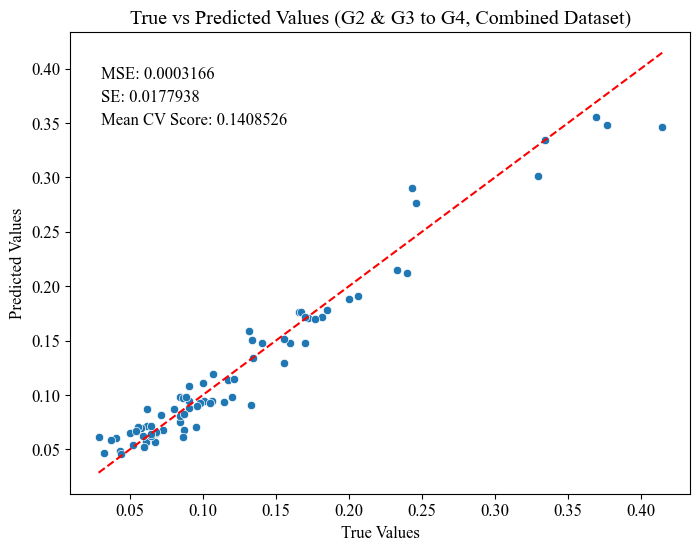

In [5]:

# Data visualization
y_true_grouped_G2_G3_G4_combined_flat = y_test_grouped_G4_combined.to_numpy().flatten()
y_pred_grouped_G2_G3_G4_combined_flat = y_pred_grouped_G2_G3_G4_combined.flatten()
df_plot_grouped_G2_G3_G4_combined = pd.DataFrame({'True Values': y_true_grouped_G2_G3_G4_combined_flat, 'Predicted Values': y_pred_grouped_G2_G3_G4_combined_flat})
plt.figure(figsize=(8, 6))
sns.scatterplot(x='True Values', y='Predicted Values', data=df_plot_grouped_G2_G3_G4_combined)
plt.plot([min(y_true_grouped_G2_G3_G4_combined_flat), max(y_true_grouped_G2_G3_G4_combined_flat)], [min(y_true_grouped_G2_G3_G4_combined_flat), max(y_true_grouped_G2_G3_G4_combined_flat)], color='red', linestyle='--')
plt.title('True vs Predicted Values (G2 & G3 to G4, Combined Dataset)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')
plt.annotate(f'MSE: {mse_grouped_G2_G3_G4_combined:.7f}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.annotate(f'SE: {se_grouped_G2_G3_G4_combined:.7f}', xy=(0.05, 0.85), xycoords='axes fraction')
plt.annotate(f'Mean CV Score: {mean_cv_score:.7f}', xy=(0.05, 0.8), xycoords='axes fraction')
# plt.savefig('../figure/figure5.pdf')
plt.show()


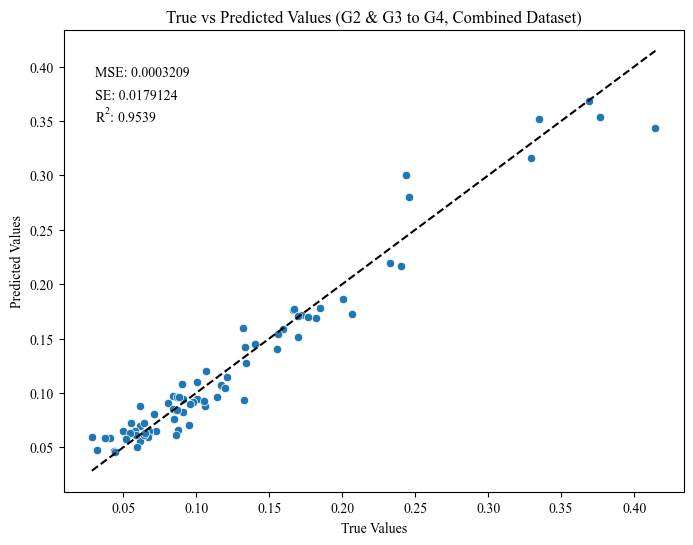

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score

import matplotlib as mpl
mpl.rcParams['font.family'] = 'Times New Roman'
import matplotlib as mpl
import matplotlib.pyplot as plt

# 设置字体为 Times New Roman，包括数学公式字体
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'


# 将真实值和预测值展平
y_true_grouped_G2_G3_G4_combined_flat = y_test_grouped_G4_combined.to_numpy().flatten()
y_pred_grouped_G2_G3_G4_combined_flat = y_pred_grouped_G2_G3_G4_combined.flatten()

# 创建用于绘图的 DataFrame
df_plot_grouped_G2_G3_G4_combined = pd.DataFrame({
    'True Values': y_true_grouped_G2_G3_G4_combined_flat,
    'Predicted Values': y_pred_grouped_G2_G3_G4_combined_flat
})

# 计算 R² 值
r2 = r2_score(y_true_grouped_G2_G3_G4_combined_flat, y_pred_grouped_G2_G3_G4_combined_flat)

# 计算其他指标（假设这些变量已经定义）
mse_grouped_G2_G3_G4_combined = mean_squared_error(y_true_grouped_G2_G3_G4_combined_flat, y_pred_grouped_G2_G3_G4_combined_flat)
# se_grouped_G2_G3_G4_combined 和 mean_cv_score 需要提前计算

# 绘制散点图
plt.figure(figsize=(8, 6))
sns.scatterplot(x='True Values', y='Predicted Values', data=df_plot_grouped_G2_G3_G4_combined)

# 绘制 y=x 参考线
min_val = min(y_true_grouped_G2_G3_G4_combined_flat.min(), y_pred_grouped_G2_G3_G4_combined_flat.min())
max_val = max(y_true_grouped_G2_G3_G4_combined_flat.max(), y_pred_grouped_G2_G3_G4_combined_flat.max())
plt.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')

# 设置标题和标签
plt.title('True vs Predicted Values (G2 & G3 to G4, Combined Dataset)')
plt.xlabel('True Values')
plt.ylabel('Predicted Values')

# 添加注释
plt.annotate(f'MSE: {mse_grouped_G2_G3_G4_combined:.7f}', xy=(0.05, 0.9), xycoords='axes fraction')
plt.annotate(f'SE: {se_grouped_G2_G3_G4_combined:.7f}', xy=(0.05, 0.85), xycoords='axes fraction')
# plt.annotate(f'Mean CV Score: {mean_cv_score:.7f}', xy=(0.05, 0.8), xycoords='axes fraction')
plt.annotate(f'R$^2$: {r2:.4f}', xy=(0.05, 0.8), xycoords='axes fraction')  # 添加 R² 注释

# 显示图形
# plt.savefig('../figure/figure5.pdf')
# plt.show()
plt.savefig('C:/Users/DuYih/Desktop/figure5.pdf')


C:\Users\DuYih\AppData\Local\Temp\ipykernel_4836\2506023201.py:43: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_max = max(means[i] + std_devs[i], means[j] + std_devs[j]) + std_devs[i]/10


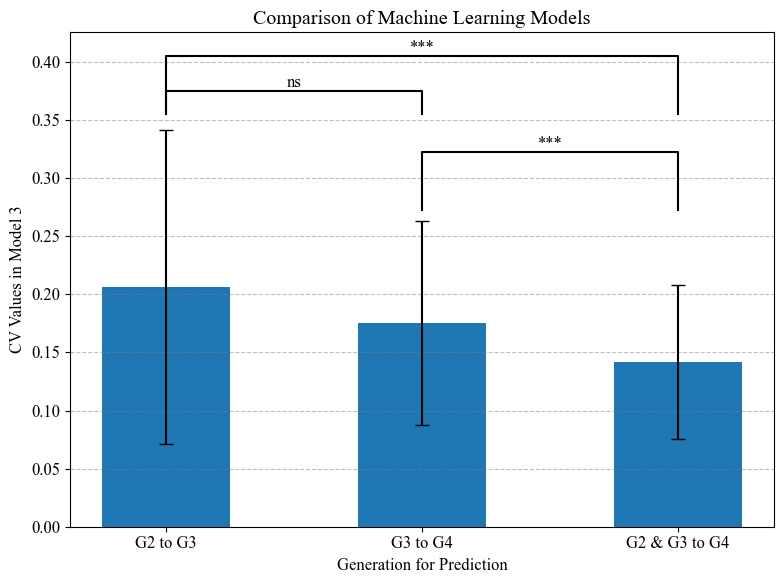

In [46]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import ttest_rel

# 设置全局字体为 Times New Roman
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 12  # 可选：设置全局字体大小

file_path = 'CV tavle.csv'
df = pd.read_csv(file_path)

means = df.mean()
std_devs = df.std()

# 创建绘图窗口
fig, ax = plt.subplots(figsize=(8,6))  # 将 figsize 移至 subplots 中

# 创建误差棒图
bars = ax.bar(df.columns, means, yerr=std_devs, capsize=5, width=0.5)

# 定义一个函数，根据 p 值返回星号的数量
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'

# 添加显著性标记
for i in range(len(df.columns)):
    for j in range(i+1, len(df.columns)):
        # 获取两组数据
        group1 = df[df.columns[i]]
        group2 = df[df.columns[j]]
        # 执行配对 t 检验
        t_stat, p_val = ttest_rel(group1, group2)
        # 获取显著性标记
        significance = get_significance_stars(p_val)
        # 计算 y 轴上的最大值，用于绘制线条和标记
        y_max = max(means[i] + std_devs[i], means[j] + std_devs[j]) + std_devs[i]/10
        
        if significance != 'ns':
            # 绘制显著性线条
            ax.plot([i, i, j, j], [y_max, y_max + 0.05, y_max + 0.05, y_max], lw=1.5, c='black')
            # 添加显著性标记
            ax.text((i + j) / 2, y_max + 0.05, significance, ha='center', va='bottom', color='black')
        else:
            # 绘制非显著性线条
            ax.plot([i, i, j, j], [y_max, y_max + 0.02, y_max + 0.02, y_max], lw=1.5, c='black')
            # 添加非显著性标记
            ax.text((i + j) / 2, y_max + 0.02, significance, ha='center', va='bottom', color='black')

# 设置轴标签和标题
ax.set_ylabel('CV Values in Model 3')
ax.set_xlabel('Generation for Prediction')
ax.set_title('Comparison of Machine Learning Models')

# 可选：调整 x 轴标签的旋转角度以提高可读性
# plt.xticks(rotation=45)

# 可选：添加网格线
ax.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# 自动调整布局
plt.tight_layout()

# 显示图形
# plt.savefig('../figure/figure5b.pdf', dpi=900)
# plt.show()
plt.savefig('C:/Users/DuYih/Desktop/figure5b.pdf')


C:\Users\DuYih\AppData\Local\Temp\ipykernel_16072\3191670285.py:99: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y_max = max(means[i] + std_devs[i], means[j] + std_devs[j]) + std_devs[i]/10


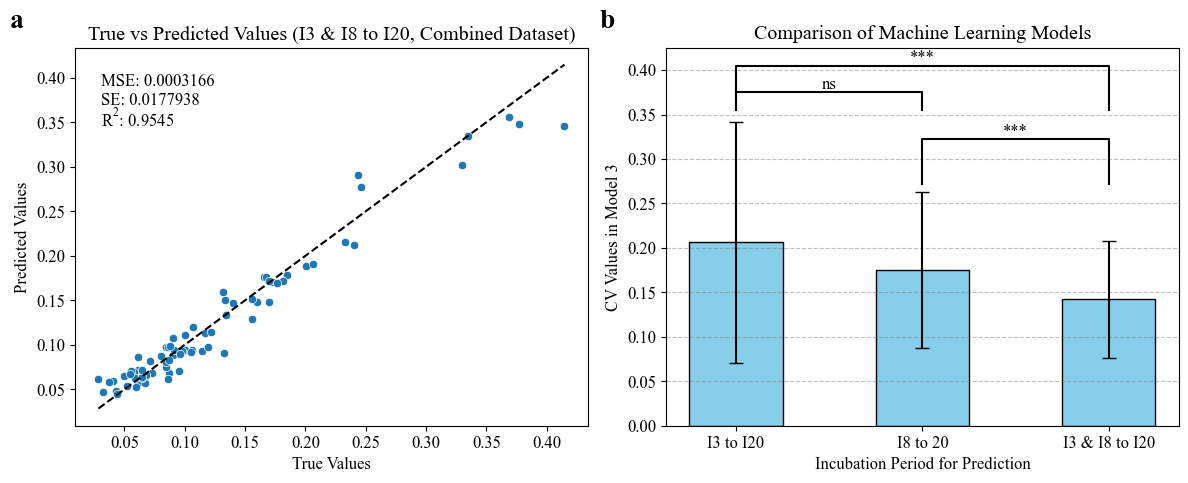

In [11]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats import ttest_rel

import matplotlib as mpl

# 设置全局字体为 Times New Roman，包括数学公式字体
mpl.rcParams['font.family'] = 'Times New Roman'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'
mpl.rcParams["font.size"] = 12  # 可选：设置全局字体大小

# 创建绘图窗口，1行2列
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# ------------------- 第一个图: True vs Predicted Values -------------------
ax1 = axes[0]

# 将真实值和预测值展平
y_true_grouped_G2_G3_G4_combined_flat = y_test_grouped_G4_combined.to_numpy().flatten()
y_pred_grouped_G2_G3_G4_combined_flat = y_pred_grouped_G2_G3_G4_combined.flatten()

# 创建用于绘图的 DataFrame
df_plot_grouped_G2_G3_G4_combined = pd.DataFrame({
    'True Values': y_true_grouped_G2_G3_G4_combined_flat,
    'Predicted Values': y_pred_grouped_G2_G3_G4_combined_flat
})

# 计算 R² 值
r2 = r2_score(y_true_grouped_G2_G3_G4_combined_flat, y_pred_grouped_G2_G3_G4_combined_flat)

# 计算其他指标（假设这些变量已经定义）
mse_grouped_G2_G3_G4_combined = mean_squared_error(y_true_grouped_G2_G3_G4_combined_flat, y_pred_grouped_G2_G3_G4_combined_flat)
# se_grouped_G2_G3_G4_combined 和 mean_cv_score 需要提前计算

# 绘制散点图
sns.scatterplot(x='True Values', y='Predicted Values', data=df_plot_grouped_G2_G3_G4_combined, ax=ax1)

# 绘制 y=x 参考线
min_val = min(y_true_grouped_G2_G3_G4_combined_flat.min(), y_pred_grouped_G2_G3_G4_combined_flat.min())
max_val = max(y_true_grouped_G2_G3_G4_combined_flat.max(), y_pred_grouped_G2_G3_G4_combined_flat.max())
ax1.plot([min_val, max_val], [min_val, max_val], color='black', linestyle='--')

# 设置标题和标签
ax1.set_title('True vs Predicted Values (I3 & I8 to I20, Combined Dataset)')
ax1.set_xlabel('True Values')
ax1.set_ylabel('Predicted Values')

# 添加注释
ax1.annotate(f'MSE: {mse_grouped_G2_G3_G4_combined:.7f}', xy=(0.05, 0.9), xycoords='axes fraction')
ax1.annotate(f'SE: {se_grouped_G2_G3_G4_combined:.7f}', xy=(0.05, 0.85), xycoords='axes fraction')
# ax1.annotate(f'Mean CV Score: {mean_cv_score:.7f}', xy=(0.05, 0.8), xycoords='axes fraction')
ax1.annotate(f'R$^2$: {r2:.4f}', xy=(0.05, 0.79), xycoords='axes fraction')  # 添加 R² 注释

# 添加子图标签 "a"
ax1.text(-0.1, 1.1, 'a', transform=ax1.transAxes,
         fontsize=20, fontweight='bold', va='top', ha='right')

# ------------------- 第二个图: Comparison of Machine Learning Models -------------------
ax2 = axes[1]

# 读取数据
file_path = 'CV tavle.csv'
df = pd.read_csv(file_path)

means = df.mean()
std_devs = df.std()

# 创建误差棒图
bars = ax2.bar(df.columns, means, yerr=std_devs, capsize=5, width=0.5, color='skyblue', edgecolor='black')

# 定义一个函数，根据 p 值返回星号的数量
def get_significance_stars(p_value):
    if p_value < 0.001:
        return '***'
    elif p_value < 0.01:
        return '**'
    elif p_value < 0.05:
        return '*'
    else:
        return 'ns'

# 添加显著性标记
num_cols = len(df.columns)
for i in range(num_cols):
    for j in range(i+1, num_cols):
        # 获取两组数据
        group1 = df[df.columns[i]]
        group2 = df[df.columns[j]]
        # 执行配对 t 检验
        t_stat, p_val = ttest_rel(group1, group2)
        # 获取显著性标记
        significance = get_significance_stars(p_val)
        # 计算 y 轴上的最大值，用于绘制线条和标记
        y_max = max(means[i] + std_devs[i], means[j] + std_devs[j]) + std_devs[i]/10

        if significance != 'ns':
            # 绘制显著性线条
            ax2.plot([i, i, j, j], [y_max, y_max + 0.05, y_max + 0.05, y_max], lw=1.5, c='black')
            # 添加显著性标记
            ax2.text((i + j) / 2, y_max + 0.05, significance, ha='center', va='bottom', color='black')
        else:
            # 绘制非显著性线条
            ax2.plot([i, i, j, j], [y_max, y_max + 0.02, y_max + 0.02, y_max], lw=1.5, c='black')
            # 添加非显著性标记
            ax2.text((i + j) / 2, y_max + 0.02, significance, ha='center', va='bottom', color='black')

# 设置轴标签和标题
ax2.set_ylabel('CV Values in Model 3')
ax2.set_xlabel('Incubation Period for Prediction')
ax2.set_title('Comparison of Machine Learning Models')

# 添加网格线
ax2.yaxis.grid(True, linestyle='--', which='major', color='grey', alpha=0.5)

# 添加子图标签 "b"
ax2.text(-0.1, 1.1, 'b', transform=ax2.transAxes,
         fontsize=20, fontweight='bold', va='top', ha='right')

# 自动调整布局
plt.tight_layout()

# 保存合并后的图形
# plt.savefig('C:/Users/DuYih/Desktop/Fig5.pdf')
plt.savefig('C:/Users/DuYih/Desktop/Fig5.tif')

# 显示图形
# plt.show()
